# BTC Transaction Fee Forecasting -- Data Explorer Notebook

This Lambda function hits the following **5 endpoints** from the [mempool.space API](https://mempool.space/docs/api):

- **`GET /api/v1/fees/mempool-blocks`**  
  → Used to fetch projected mempool blocks and their fee ranges (though `feeRange` is discarded).

- **`GET /api/v1/fees/recommended`**  
  → Returns recommended fee rates for fastest, half-hour, hour, and minimum confirmation targets.

- **`GET /api/mempool`**  
  → Fetches aggregate mempool statistics (e.g. total vsize, count).

- **`GET /api/v1/difficulty-adjustment`**  
  → Gets data related to the current difficulty epoch (e.g. progress %, estimated retarget).

- **`GET /api/v1/prices`**  
  → Provides current BTC price data (probably in multiple currencies).

## Imports

In [3]:
import pandas as pd

## Ingestion

In [4]:
df = pd.read_parquet('extracted_s3.parquet')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11902 entries, 0 to 11901
Data columns (total 83 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   timestamp                                 11902 non-null  int64  
 1   mempool_blocks_blockSize                  11901 non-null  float64
 2   mempool_blocks_blockVSize                 11901 non-null  float64
 3   mempool_blocks_nTx                        11901 non-null  float64
 4   mempool_blocks_totalFees                  11901 non-null  float64
 5   mempool_blocks_medianFee                  11901 non-null  float64
 6   recommended_fee_fastestFee                11902 non-null  float64
 7   recommended_fee_halfHourFee               11902 non-null  float64
 8   recommended_fee_hourFee                   11902 non-null  float64
 9   recommended_fee_economyFee                11902 non-null  float64
 10  recommended_fee_minimumFee        

## Cleaning

### Remove histogram cols with only 0 values

In [6]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [7]:
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)

### Set timestamp as index

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11902 entries, 2025-03-05 02:12:13 to 2025-04-15 09:54:42
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  11901 non-null  float64
 1   mempool_blocks_blockVSize                 11901 non-null  float64
 2   mempool_blocks_nTx                        11901 non-null  float64
 3   mempool_blocks_totalFees                  11901 non-null  float64
 4   mempool_blocks_medianFee                  11901 non-null  float64
 5   recommended_fee_fastestFee                11902 non-null  float64
 6   recommended_fee_halfHourFee               11902 non-null  float64
 7   recommended_fee_hourFee                   11902 non-null  float64
 8   recommended_fee_economyFee                11902 non-null  float64
 9   recommended_fee_minimumFee                11902 non-null  float64
 10 

In [10]:
df

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:12:13,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:14:41,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:19:42,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:24:41,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:29:42,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 09:34:42,1731329.0,997991.75,3810.0,4524017.0,2.149812,3.0,3.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-15 09:39:41,1593473.0,997958.75,3874.0,3061643.0,2.000000,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-04-15 09:44:41,1732510.0,997988.50,4511.0,4356829.0,1.554327,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       mempool_blocks_blockSize  mempool_blocks_blockVSize  \
count              1.190100e+04               11901.000000   
mean               1.559835e+06              934792.751639   
std                3.834879e+05              193006.781627   
min                7.501000e+03                4367.250000   
25%                1.486038e+06              997909.250000   
50%                1.621340e+06              997952.250000   
75%                1.740367e+06              997982.000000   
max                3.889621e+06              997999.750000   

       mempool_blocks_nTx  mempool_blocks_totalFees  mempool_blocks_medianFee  \
count        11901.000000              1.190100e+04              11901.000000   
mean          2661.582724              3.914089e+06                  2.630856   
std           1170.740546              3.618740e+06                  5.128006   
min             15.000000              1.565800e+04                  0.000000   
25%           1

In [14]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
mempool_blocks_blockSize             1
mempool_blocks_blockVSize            1
mempool_blocks_nTx                   1
mempool_blocks_totalFees             1
mempool_blocks_medianFee             1
                                    ..
mempool_fee_histogram_bin_95_100     0
mempool_fee_histogram_bin_100_150    0
mempool_fee_histogram_bin_150_200    0
mempool_fee_histogram_bin_200_250    0
mempool_fee_histogram_bin_250_300    0
Length: 67, dtype: int64


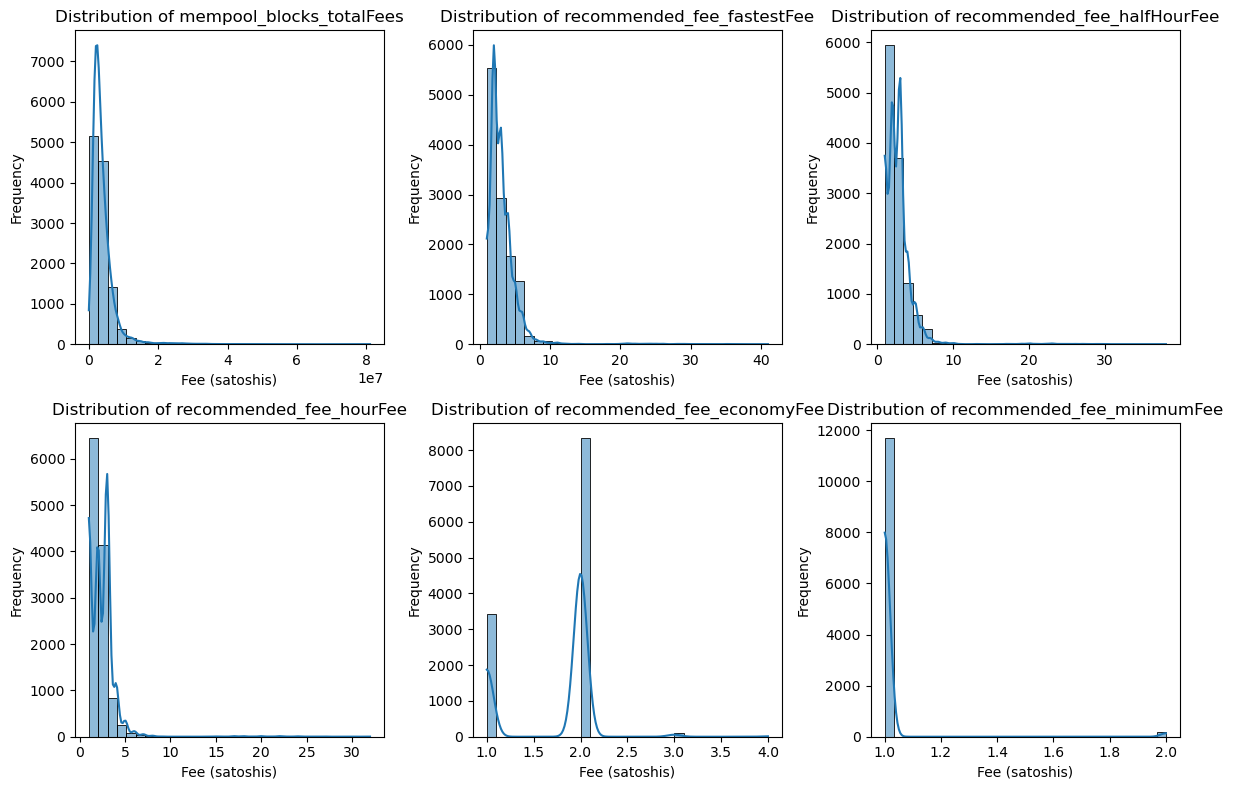

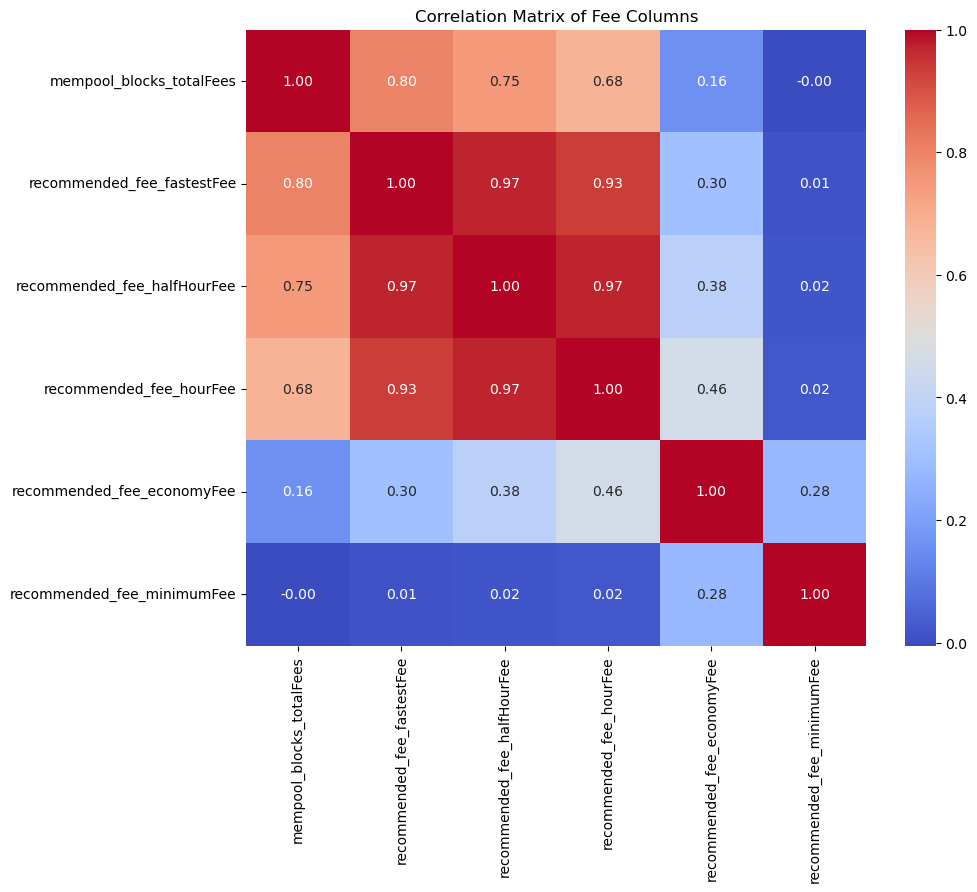

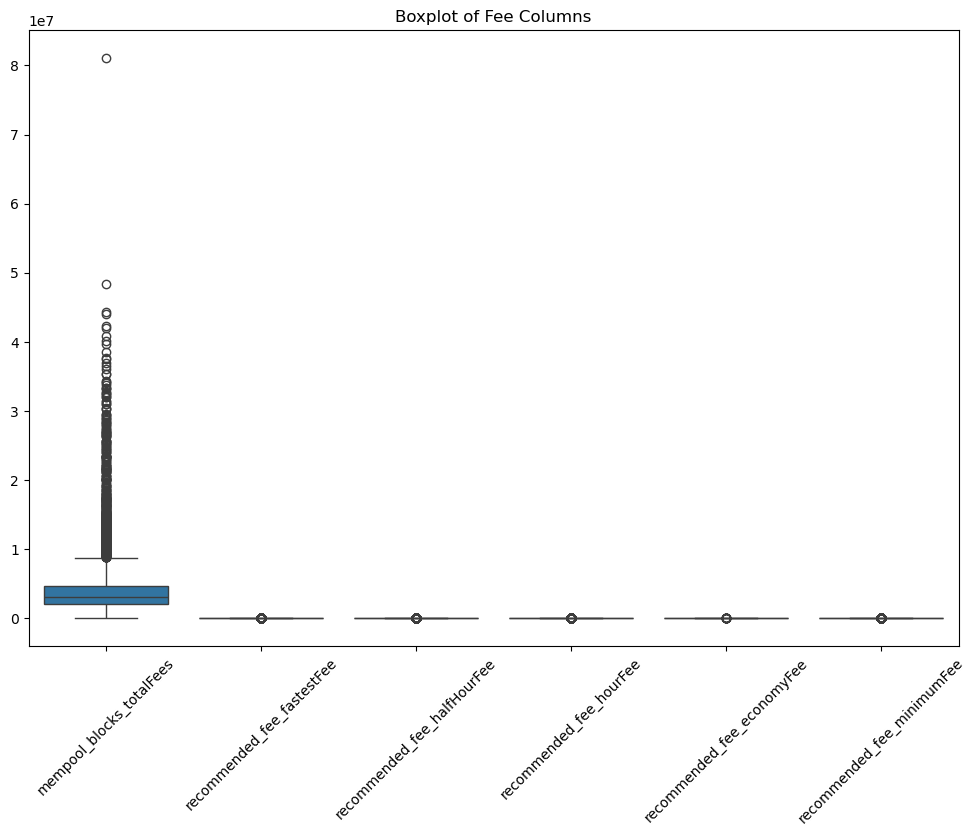

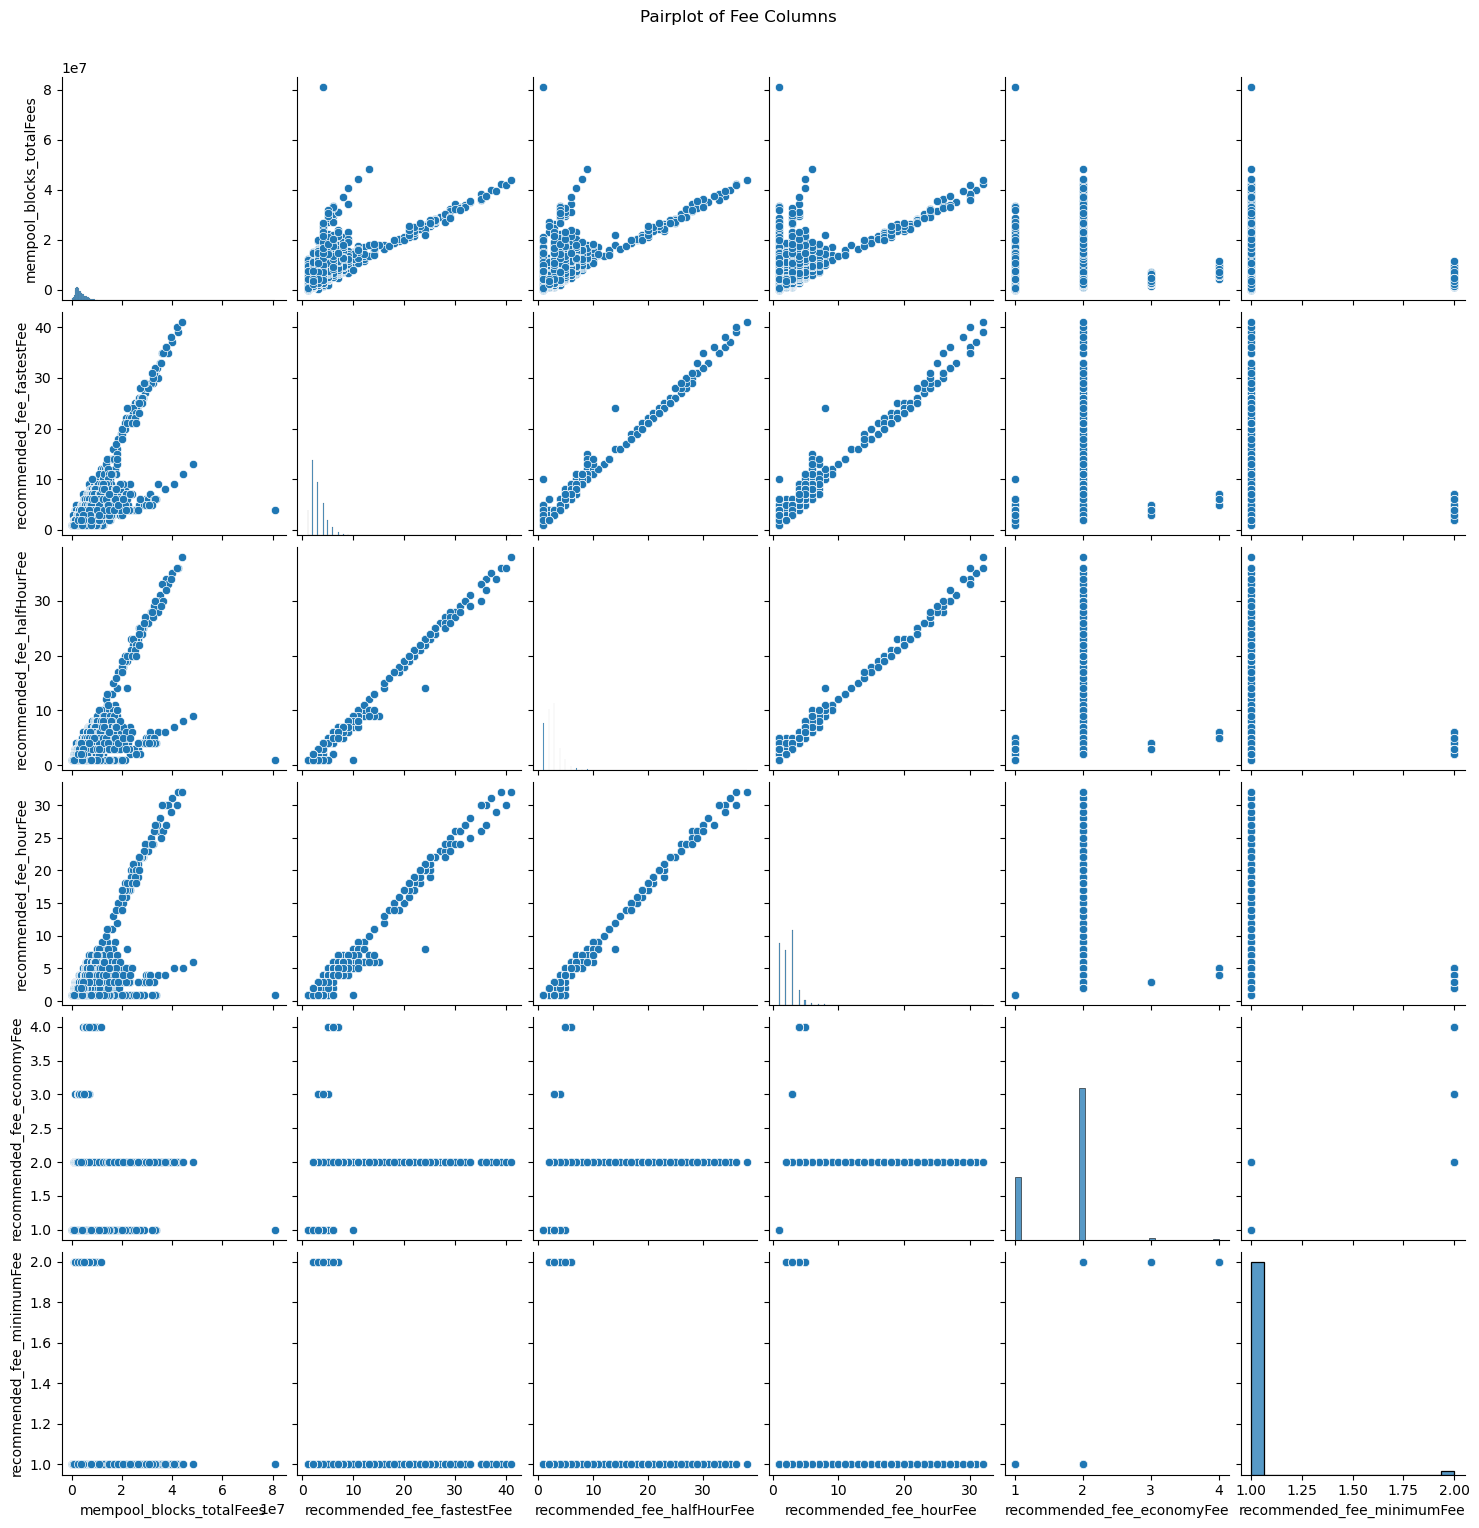

In [ ]:
# Visualize distributions of key fee histogram columns (variables of interest))
fee_bin_columns = [
    'mempool_fee_histogram_bin_70_75', 'mempool_fee_histogram_bin_75_80', 'mempool_fee_histogram_bin_80_85',
    'mempool_fee_histogram_bin_85_90', 'mempool_fee_histogram_bin_90_95', 'mempool_fee_histogram_bin_95_100',
    'mempool_fee_histogram_bin_100_150', 'mempool_fee_histogram_bin_150_200',
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(fee_bin_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Fee Bin (satoshis)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[fee_bin_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fee Bin Columns')
plt.show()

# Boxplot to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[fee_bin_columns])
plt.title('Boxplot of Fee Bin Columns')
plt.xticks(rotation=45)
plt.show()

# Pairplot to explore relationships between fee columns
sns.pairplot(df[fee_bin_columns])
plt.suptitle('Pairplot of Fee Bin Columns', y=1.02)
plt.show()

In [ ]:
# Visualize distributions of key fee columns (Y response of interest)
fee_columns = [
    'mempool_blocks_totalFees', 'recommended_fee_fastestFee',
    'recommended_fee_halfHourFee', 'recommended_fee_hourFee',
    'recommended_fee_economyFee', 'recommended_fee_minimumFee'
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(fee_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Fee (satoshis)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[fee_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fee Columns')
plt.show()

# Boxplot to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[fee_columns])
plt.title('Boxplot of Fee Columns')
plt.xticks(rotation=45)
plt.show()

# Pairplot to explore relationships between fee columns
sns.pairplot(df[fee_columns])
plt.suptitle('Pairplot of Fee Columns', y=1.02)
plt.show()